拿加權指數資料去訓練AE

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [9]:
# 讀取 CSV 檔案
file_path = "資料前處理/merged_stocks.csv"
df = pd.read_csv(file_path)
#print(df.head())
# 假設我們要使用數值型的列來做 Autoencoder
#df = df.select_dtypes(include=[np.number]).dropna()

print(df.head())

           日期        成交股數           成交金額    開盤價    最高價    最低價    收盤價   漲跌價差  \
0  2010-10-21  20,697,571  2,347,730,094  114.0  114.5  112.5  113.0  -1.00   
1  2010-10-22  16,111,879  1,833,691,206  114.5  114.5  113.0  114.0  +1.00   
2  2010-10-25  46,473,212  5,436,268,687  114.0  118.5  114.0  118.5  +4.50   
3  2010-10-26  17,656,603  2,082,389,977  119.0  119.0  117.0  118.0  -0.50   
4  2010-10-27  16,083,156  1,881,557,596  118.0  119.0  116.0  116.0  -2.00   

     成交筆數  SMA_5  ...   SMA_200       EMA_5      EMA_20        RSI      MACD  \
0   9,188  113.6  ...  129.9400  113.598253  115.156901  42.888466 -1.067839   
1   6,509  113.2  ...  129.7525  113.732169  115.046720  45.751457 -1.032347   
2  22,716  114.3  ...  129.5825  115.321446  115.375604  56.354543 -0.633800   
3   8,893  115.5  ...  129.4150  116.214297  115.625547  55.066664 -0.354212   
4   7,269  115.9  ...  129.2450  116.142865  115.661209  50.131500 -0.290669   

   MACD_signal  MACD_hist  Support_Level  Re

移除不需要的欄位 如日期股票代號

In [10]:
df = df.drop(columns=['日期', '股票代碼'])

# 查看結果
print(df.head())
print(df.columns)
print(df.info())

         成交股數           成交金額    開盤價    最高價    最低價    收盤價   漲跌價差    成交筆數  \
0  20,697,571  2,347,730,094  114.0  114.5  112.5  113.0  -1.00   9,188   
1  16,111,879  1,833,691,206  114.5  114.5  113.0  114.0  +1.00   6,509   
2  46,473,212  5,436,268,687  114.0  118.5  114.0  118.5  +4.50  22,716   
3  17,656,603  2,082,389,977  119.0  119.0  117.0  118.0  -0.50   8,893   
4  16,083,156  1,881,557,596  118.0  119.0  116.0  116.0  -2.00   7,269   

   SMA_5   SMA_20  ...  SMA_50   SMA_200       EMA_5      EMA_20        RSI  \
0  113.6  115.825  ...  117.92  129.9400  113.598253  115.156901  42.888466   
1  113.2  115.650  ...  117.60  129.7525  113.732169  115.046720  45.751457   
2  114.3  115.725  ...  117.36  129.5825  115.321446  115.375604  56.354543   
3  115.5  115.750  ...  117.08  129.4150  116.214297  115.625547  55.066664   
4  115.9  115.675  ...  116.77  129.2450  116.142865  115.661209  50.131500   

       MACD  MACD_signal  MACD_hist  Support_Level  Resistance_Level  
0 -

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch

# 讀取數據
print(df.head())
print(df.dtypes)

# 轉換日期為數字格式
# 處理民國年格式的日期 (例如: "113/01/02" → "2024/01/02")
#def convert_to_gregorian(date_str):
    #year, month, day = date_str.split('/')
    #year = int(year) + 1911  # 將民國年轉換為西元年
    #return f"{year}/{month}/{day}"

#df['日期'] = df['日期'].apply(convert_to_gregorian)
#df['日期'] = pd.to_datetime(df['日期'], format='%Y/%m/%d')
#df['year'] = df['日期'].dt.year
#df['month'] = df['日期'].dt.month
#df['day'] = df['日期'].dt.day
#df['day_of_week'] = df['日期'].dt.dayofweek  # 0=星期一, 6=星期日

# 處理股票代碼 (將股票代碼轉換為數字類別)
#label_encoder = LabelEncoder()
#df['股票代碼'] = label_encoder.fit_transform(df['股票代碼'].astype(str))

# 處理成交量 (移除逗號，轉換為浮點數)
#df['成交股數'] = df['成交股數'].str.replace(',', '').astype(float)
#df['成交金額'] = df['成交金額'].str.replace(',', '').astype(float)
#df['成交筆數'] = df['成交筆數'].str.replace(',', '').astype(float)

# 將 '漲跌價差' 欄位的正負號去掉，安全地轉換為浮點數，並處理非數字情況
#df['漲跌價差'] = pd.to_numeric(df['漲跌價差'].str.replace('B', '').str.replace('[+,]', '', regex=True), errors='coerce').fillna(0)

print(df['漲跌價差'].head())



# 列出所有需要轉換為 float 的欄位
float_columns = ['成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數', 'SMA_5',
       'SMA_20', 'SMA_60', 'SMA_50', 'SMA_200', 'EMA_5', 'EMA_20', 'RSI',
       'MACD', 'MACD_signal', 'MACD_hist', 'Support_Level',
       'Resistance_Level']


df[float_columns] = df[float_columns].replace("X0.00", "0")
# 移除 `,` 並轉換為 float
for col in float_columns:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# 移除原始日期欄位
#df.drop(columns=['日期'], inplace=True)

# 確保所有數據都是數值型
print(df.dtypes)
print(df.head())

# 進行標準化處理
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df.values)

print("標準化後的數據:")
print(data_scaled[:5])

# 轉換為 PyTorch Tensor
data_tensor = torch.tensor(data_scaled, dtype=torch.float32)

# 查看處理後的數據形狀
print("數據張量形狀:", data_tensor.shape)


         成交股數          成交金額    開盤價    最高價    最低價    收盤價  漲跌價差     成交筆數  SMA_5  \
0  20697571.0  2.347730e+09  114.0  114.5  112.5  113.0  -1.0   9188.0  113.6   
1  16111879.0  1.833691e+09  114.5  114.5  113.0  114.0   1.0   6509.0  113.2   
2  46473212.0  5.436269e+09  114.0  118.5  114.0  118.5   4.5  22716.0  114.3   
3  17656603.0  2.082390e+09  119.0  119.0  117.0  118.0  -0.5   8893.0  115.5   
4  16083156.0  1.881558e+09  118.0  119.0  116.0  116.0  -2.0   7269.0  115.9   

    SMA_20  ...  SMA_50   SMA_200       EMA_5      EMA_20        RSI  \
0  115.825  ...  117.92  129.9400  113.598253  115.156901  42.888466   
1  115.650  ...  117.60  129.7525  113.732169  115.046720  45.751457   
2  115.725  ...  117.36  129.5825  115.321446  115.375604  56.354543   
3  115.750  ...  117.08  129.4150  116.214297  115.625547  55.066664   
4  115.675  ...  116.77  129.2450  116.142865  115.661209  50.131500   

       MACD  MACD_signal  MACD_hist  Support_Level  Resistance_Level  
0 -1.0678

In [15]:
print(torch.isnan(data_tensor).sum())  # NaN 個數
print(torch.isinf(data_tensor).sum())  # 無窮大個數

tensor(0)
tensor(0)


In [16]:
nan_rows = torch.any(torch.isnan(data_tensor), dim=1)
print("含 NaN 的行索引:", torch.nonzero(nan_rows))
print("含 NaN 的數據:", data_tensor[nan_rows])


含 NaN 的行索引: tensor([], size=(0, 1), dtype=torch.int64)
含 NaN 的數據: tensor([], size=(0, 21))


Epoch [1/100], Loss: 0.0569
Epoch [2/100], Loss: 0.0728
Epoch [3/100], Loss: 0.1830
Epoch [4/100], Loss: 0.0770
Epoch [5/100], Loss: 0.6709
Epoch [6/100], Loss: 0.0393
Epoch [7/100], Loss: 0.1497
Epoch [8/100], Loss: 0.2989
Epoch [9/100], Loss: 0.2491
Epoch [10/100], Loss: 0.0720
Epoch [11/100], Loss: 0.0872
Epoch [12/100], Loss: 0.3255
Epoch [13/100], Loss: 0.0382
Epoch [14/100], Loss: 0.0431
Epoch [15/100], Loss: 0.1332
Epoch [16/100], Loss: 0.3757
Epoch [17/100], Loss: 0.0168
Epoch [18/100], Loss: 0.0749
Epoch [19/100], Loss: 0.0260
Epoch [20/100], Loss: 0.1094
Epoch [21/100], Loss: 0.4569
Epoch [22/100], Loss: 0.4192
Epoch [23/100], Loss: 0.1333
Epoch [24/100], Loss: 0.0383
Epoch [25/100], Loss: 0.0285
Epoch [26/100], Loss: 0.0879
Epoch [27/100], Loss: 0.1693
Epoch [28/100], Loss: 0.0246
Epoch [29/100], Loss: 0.4507
Epoch [30/100], Loss: 0.0596
Epoch [31/100], Loss: 0.0955
Epoch [32/100], Loss: 0.0452
Epoch [33/100], Loss: 0.1778
Epoch [34/100], Loss: 0.1097
Epoch [35/100], Loss: 0

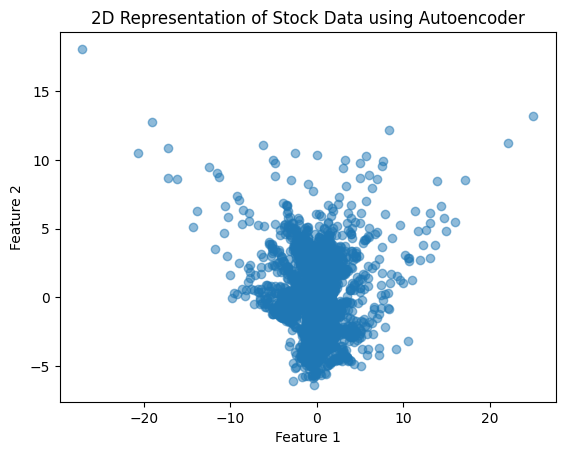

In [23]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 設定 batch size
batch_size = 32
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 定義 Autoencoder
class AutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # 壓縮到 2 維
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)  # 重建原始輸入
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z

# 初始化模型
input_dim = data_tensor.shape[1]  # 現在的特徵數
model = AutoEncoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練模型
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    for batch in dataloader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        x_reconstructed, _ = model(x)
        loss = criterion(x_reconstructed, x)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# 提取 2D 特徵
model.eval()
encoded_data = model.encoder(data_tensor.to(device)).detach().cpu().numpy()

# 可視化 2D 壓縮後的數據
import matplotlib.pyplot as plt
encoded_df = pd.DataFrame(encoded_data, columns=["Feature1", "Feature2"])
plt.scatter(encoded_df["Feature1"], encoded_df["Feature2"], alpha=0.5)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("2D Representation of Stock Data using Autoencoder")
plt.show()


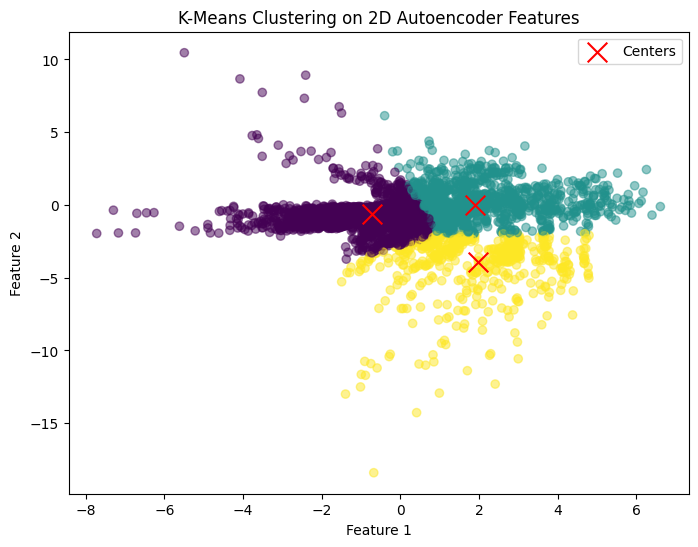

In [21]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 進行 K-Means 分群
num_clusters = 3  # 你可以嘗試不同數值
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(encoded_data)  # 取得每個點的群集標籤

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=200, label="Centers")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("K-Means Clustering on 2D Autoencoder Features")
plt.legend()
plt.show()


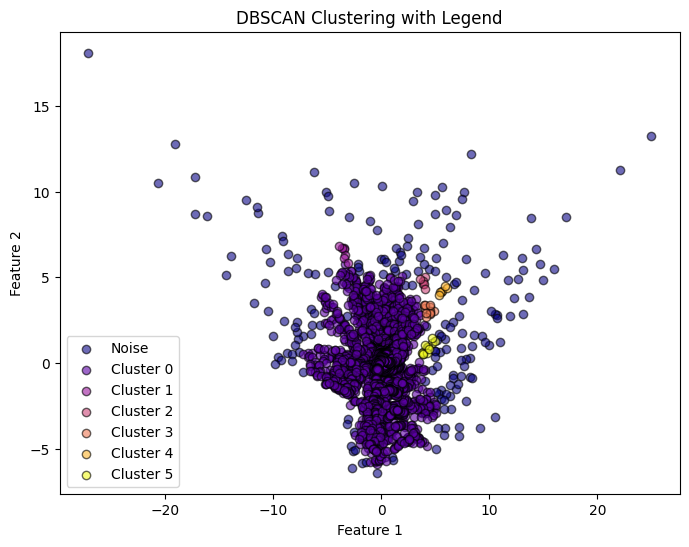

In [24]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# 執行 DBSCAN 分群
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(encoded_data)  # 每個點的群集標籤

# 取得唯一的群集標籤
unique_clusters = np.unique(clusters)

# 建立顏色對應表
colors = plt.cm.plasma(np.linspace(0, 1, len(unique_clusters)))  # 使用 plasma colormap

plt.figure(figsize=(8, 6))

# 繪製每個群集
for cluster, color in zip(unique_clusters, colors):
    mask = clusters == cluster  # 取得當前群集的索引
    label = f"Cluster {cluster}" if cluster != -1 else "Noise"  # -1 代表雜訊
    plt.scatter(encoded_data[mask, 0], encoded_data[mask, 1], c=[color], label=label, alpha=0.6, edgecolors='k')

# 加上圖例
plt.legend()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("DBSCAN Clustering with Legend")
plt.show()
